# Tracking metrics in custom training loops
In this reading you will learn how to track metrics such as accuracy within custom training loops. 

In [17]:
import tensorflow as tf
print(tf.__version__)

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]
)

2.3.1


Tracking performance metrics is useful to check the performance of your model during and after training. Previously, we have passed in a list of metrics to the `model.fit` or `model.evaluate` methods when using the higher level APIs. However, we would still like to be able to evaluate our model on performance metrics in a custom training loop.

## Load the dataset
For this reading notebook we will use the Reuters dataset. The cells below load and process the dataset, and prepare it as `tf.data.Dataset` objects.

In [60]:
# Load the dataset

from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000, skip_top=50)

print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)

(8982,) (8982,)
(2246,) (2246,)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [61]:
# Define the class names

class_names = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

In [62]:
# Pad and truncate the train and test inputs

from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_train_data = pad_sequences(train_data, maxlen=100, truncating='post')
padded_test_data = pad_sequences(test_data, maxlen=100, truncating='post')

In [63]:
# Split the training data into training and validation sets

from sklearn.model_selection import train_test_split

# train_data, val_data, train_labels, val_labels = train_test_split(padded_train_data, train_labels, 
#                                                                   test_size=0.3)
train_data, val_data, train_labels, val_labels = train_test_split(padded_train_data, train_labels, 
                                                                  test_size=0.1)

In [64]:
# Create Datasets for training, validation and test data

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels))
val_dataset = val_dataset.shuffle(500)
val_dataset = val_dataset.batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((padded_test_data, test_labels))
test_dataset = test_dataset.batch(32)

## Define the model, optimizer and loss function

Before getting to the custom training loop, we first define the model. We will use the model subclassing API to build a recurrent neural network for this example.

In [56]:
# Build the model

from tensorflow.keras.layers import Embedding, GRU, Bidirectional, Dense
from tensorflow.keras.models import Model

class RNNModel(Model):

    def __init__(self, units_1, units_2, num_classes, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.embedding = Embedding(input_dim=10000, output_dim=16, input_length=100)
        self.gru_1 = Bidirectional(GRU(units_1, return_sequences=True), merge_mode='sum')
        self.gru_2 = GRU(units_2)
        self.dense = Dense(num_classes, activation='softmax')

    def call(self, inputs):
        h = self.embedding(inputs)
        h = self.gru_1(h)
        h = self.gru_2(h)
        return self.dense(h)

In [57]:
# Instantiate the model

model = RNNModel(units_1=32, units_2=16, num_classes=46, name='rnn_model')


We will use the `SGD` optimizer with Nesterov momentum, and a learning rate of 0.005:

In [51]:
# Define the optimizer

# optimizer = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9, nesterov=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

The loss function for our model should be the sparse categorical cross entropy, since the labels are in sparse form:

In [52]:
# Define the loss

loss = tf.keras.losses.SparseCategoricalCrossentropy()

## Build the custom training loop

The following function computes the model predictions, loss and gradients, for use in the custom training loop.

In [53]:
# Define a function to compute the loss and gradients

def grad(model, inputs, targets, loss):
    with tf.GradientTape() as tape:
        preds = model(inputs)
        loss_value = loss(targets, preds)
    return preds, loss_value, tape.gradient(loss_value, model.trainable_variables)

Metric objects can be created and used to track performance measures in the custom training loop. We will set up our custom training loop to track the average loss, and area under the [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) (ROC AUC). Of course there are many more metrics that you could use. 

In [54]:
# Create lists to accumulate the metric values

train_loss_results = []
train_roc_auc_results = []
train_accuracy_results = []

val_loss_results = []
val_roc_auc_results = []
val_accuracy_results = []

In the following custom training loop, we define an outer loop for the epochs, and an inner loop for the batches in the training dataset. At the end of each epoch we run a validation loop for a number of iterations.

Inside the inner loop we use the metric objects to calculate the metric evaluation values. These values are then appended to the empty lists. The metric objects are re-initialised at the start of each epoch.

The following training loop may take a while to run. Feel free to reduce the number of epochs if you want.

In [65]:
model = RNNModel(units_1=32, units_2=16, num_classes=46, name='rnn_model')

In [66]:
# Run the custom training loop

from tensorflow.keras.utils import to_categorical

num_epochs = 10
val_steps = 10

for epoch in range(num_epochs):
    train_epoch_loss_avg = tf.keras.metrics.Mean()
    train_epoch_roc_auc = tf.keras.metrics.AUC(curve='ROC')
    train_epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()
    
    val_epoch_loss_avg = tf.keras.metrics.Mean()
    val_epoch_roc_auc = tf.keras.metrics.AUC(curve='ROC')    
    val_epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

    for inputs, labels in train_dataset:
        model_preds, loss_value, grads = grad(model, inputs, labels, loss)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        train_epoch_loss_avg(loss_value)
        train_epoch_roc_auc(to_categorical(labels, num_classes=46), model_preds)
        train_epoch_accuracy(to_categorical(labels, num_classes=46), model_preds)
        
    for inputs, labels in val_dataset.take(val_steps):
        model_preds = model(inputs)
        val_epoch_loss_avg(loss(labels, model_preds))
        val_epoch_roc_auc(to_categorical(labels, num_classes=46), model_preds)
        val_epoch_accuracy(to_categorical(labels, num_classes=46), model_preds)
        
    train_loss_results.append(train_epoch_loss_avg.result().numpy())
    train_roc_auc_results.append(train_epoch_roc_auc.result().numpy())
    train_accuracy_results.append(train_epoch_accuracy.result().numpy())
    
    val_loss_results.append(val_epoch_loss_avg.result().numpy())
    val_roc_auc_results.append(val_epoch_roc_auc.result().numpy())
    val_accuracy_results.append(val_epoch_accuracy.result().numpy())

    print("Epoch {:03d}: Training loss: {:.3f}, ROC AUC: {:.3%}, Accuracy={:.3%}".format(epoch, 
                                                                                         train_epoch_loss_avg.result(),
                                                                                         train_epoch_roc_auc.result(),
                                                                                         train_epoch_accuracy.result()
                                                                                        ))
    print("           Validation loss: {:.3f}, ROC AUC {:.3%}, Accuracy={:.3%}".format(val_epoch_loss_avg.result(),
                                                                                          val_epoch_roc_auc.result(),
                                                                                          val_epoch_accuracy.result()
                                                                                         ))

Epoch 000: Training loss: 2.355, ROC AUC: 89.434%, Accuracy=38.043%
           Validation loss: 2.197, ROC AUC 89.342%, Accuracy=46.875%
Epoch 001: Training loss: 1.884, ROC AUC: 92.413%, Accuracy=52.010%
           Validation loss: 1.904, ROC AUC 91.635%, Accuracy=51.562%
Epoch 002: Training loss: 1.736, ROC AUC: 93.114%, Accuracy=54.497%
           Validation loss: 1.754, ROC AUC 92.593%, Accuracy=56.875%
Epoch 003: Training loss: 1.648, ROC AUC: 93.769%, Accuracy=58.840%
           Validation loss: 1.759, ROC AUC 92.520%, Accuracy=57.187%
Epoch 004: Training loss: 1.578, ROC AUC: 94.230%, Accuracy=60.015%
           Validation loss: 1.720, ROC AUC 92.971%, Accuracy=56.563%
Epoch 005: Training loss: 1.524, ROC AUC: 94.599%, Accuracy=61.277%
           Validation loss: 1.727, ROC AUC 93.854%, Accuracy=55.313%
Epoch 006: Training loss: 1.472, ROC AUC: 95.048%, Accuracy=63.071%
           Validation loss: 1.718, ROC AUC 93.358%, Accuracy=56.875%
Epoch 007: Training loss: 1.424, ROC AUC:

In [69]:
test_accuracy = tf.keras.metrics.CategoricalAccuracy()
test_accuracy(to_categorical(test_labels, num_classes=46), model(padded_test_data))
print('accuarcy is', test_accuracy.result().numpy())

accuarcy is 0.5823687


为什么上面的性能，好像反而大大不如Week_4_Model_subclassing中采用MLP的模型?

- SGD换成Adam，Accuarcy的确大大提高
- 把Valdiation的比例由0.3减少到0.1, 好像效果不明显。

可能这个模型需要太多数据了把，所以模型不能取得理想的结果。

#### Plot the learning curves

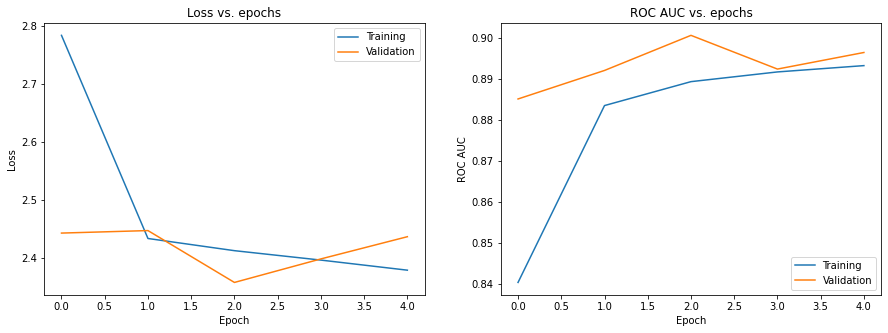

In [33]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(121)
plt.plot(train_loss_results)
plt.plot(val_loss_results)
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)
plt.plot(train_roc_auc_results)
plt.plot(val_roc_auc_results)
plt.title('ROC AUC vs. epochs')
plt.ylabel('ROC AUC')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

## Test the model
Similarly, we can calculate the loss and metric values on the test dataset.

In [36]:
# Create metric objects for testing

test_epoch_loss_avg = tf.keras.metrics.Mean()
test_epoch_roc_auc = tf.keras.metrics.AUC(curve='ROC')
test_accuracy = tf.keras.metrics.CategoricalAccuracy()

In [39]:
# Calculate metrics on the test set

for inputs, labels in test_dataset:
    model_pred = model(inputs)
    test_accuracy(to_categorical(labels), model_pred)
    test_epoch_loss_avg(loss(labels, model_pred))  
    test_epoch_roc_auc(to_categorical(labels, num_classes=46), model_pred)

print("Test loss: {:.3f}".format(test_epoch_loss_avg.result().numpy()))
print("Test ROC AUC: {:.3%}".format(test_epoch_roc_auc.result().numpy()))
print("Test Accuarcy: {:.3%}".format(test_accuracy.result().numpy()))

Test loss: 2.371
Test ROC AUC: 89.090%
Test Accuarcy: 26.551%


## Further reading and resources 
* https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough#training_loop
* https://www.tensorflow.org/api_docs/python/tf/keras/metrics
* https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve